In [11]:
import matplotlib.pyplot as plt
import re
import random
import nltk.data
import spacy 
import string
from collections import Counter

## Spanish Manual Engine

In [12]:
# Most policies come with the final signatures. This is a piece of text that we want to be able to recognize. To make the
# detection of signatures easier, this dictionary contain the most common terms that can be found in these lines of text.
official_positions = {"ALCALDE" : 0,
"Alcalde" : 0,
"MINISTRA" : 0,
"Ministra" : 0,
"MINISTRO" : 0,
"Ministro" : 0,
"PRESIDENTA" : 0,
"Presidenta" : 0,
"PRESIDENTE" : 0,
"Presidente" : 0,
"REGIDOR" : 0,
"Regidor"  : 0,
"REGIDORA" : 0,
"regidora" : 0,
"SECRETARIA" : 0,
"Secretaria" : 0,
"SECRETARIO" : 0,
"Secretario" : 0,
"SINDICA" : 0,
"Sindica" : 0,
"SINDICO" : 0,
"Sindico" : 0,
"VICEPRESIDENTA" : 0,
"Vicepresidenta" : 0,
"VICEPRESIDENTE" : 0,
"Vicepresidente" : 0
}

end_of_file_tags = {
    "Anótese" : 0,
    "Anotese" : 0,
    "Publíquese" : 0,
    "Publiquese" : 0
}
# This dictionary contains some correspondences among different text headings. This is under development and needs further
# improvement.The idea is to merge in a single name all the headings that point to the same conceptual concept. For example,
# "Definiciones" is a heading that can come alone or together with other terms so it can appear as "Definiciones básicas" or
# "Definiciones generales". With the dictionary we can fetch all headings that contain the word "Definiciones" and change the
# heading to "Definiciones".
merges = {
    "CONCEPTOS" : "DISPOSICIONES GENERALES",
    "Considerando:" : "CONSIDERANDO",
    "DEFINICIONES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES FINALES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES GENERALES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES PRELIMINARES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES REGULADORAS" : "DISPOSICIONES ESPECIALES",
    "DISPOSICIONES RELATIVAS" : "DISPOSICIONES ESPECIALES",
    "DISPOSICIONES ESPECIALES" : "DISPOSICIONES ESPECIALES",
    "DISPOSICIONES TRANSITORIAS" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES VARIAS Y TRANSITORIAS" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES VARIAS" : "DISPOSICIONES GENERALES",
    "INCENTIVOS" : "INCENTIVOS",
    "INFRACCIONES" : "INFRACCIONES",
    "INFRACCION ES" : "INFRACCIONES",
    "OBJETIVO" : "OBJETO",
    "OBJETO" : "OBJETO",
    "DERECHOS" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "DEBERES" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGACIONES" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGACIONE" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGACION" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGATORIEDAD" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "PROHIBICIONES" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "PROHIBICION" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "DE LAS FORMAS DE AUTORIZACION" : "PERMISOS",
    "DE LOS PERMISOS Y LAS PATENTES" : "PERMISOS",
    "DE LOS PERMISOS" : "PERMISOS",
    "DE LAS SOLICITUDES DE PERMISOS" : "PERMISOS",
    "DEL OTORGAMIENTO DEL PERMISO" : "PERMISOS",
    "POR TANTO" : "POR TANTO",
    "POR LO TANTO" : "POR TANTO",
    "Decreto:" : "RESUELVO",
    "Resuelvo:" : "RESUELVO",
    "Se resuelve" : "RESUELVO",
    "S e  r e s u e l v e:" : "RESUELVO",
    "R e s u e l v o:" : "RESUELVO",
    "FISCALIZACION Y SANCIONES" : "SANCIONES",
    "DE LAS SANCIONES" : "SANCIONES",
    "Visto:" : "VISTO",
    "Vistos:" : "VISTO",
    "Vistos estos antecedentes:" : "VISTO",
    "--------------" : "HEADING"
}
section_tags = {
    "Considerando:" : "CONSIDERANDO",
    "Considerando\n" : "CONSIDERANDO",
    "Decreto:" : "RESUELVO",
    "Disposiciones Generales" : "DISPOSICIONES GENERALES", 
    "Resuelvo:" : "RESUELVO",
    "R e s u e l v o:" : "RESUELVO",
    "Se resuelve" : "RESUELVO",
    "S e  r e s u e l v e:" : "RESUELVO",
    "Visto:" : "VISTO",
    "Vistos:" : "VISTO",
    "Vistos estos antecedentes:" : "VISTO",
    "--------------" : "HEADING"
}
merges_lower = {}
for key, value in merges.items():
    merges_lower[key.lower()] = value
# Eventhough the general gramar rule in Spanish is not to accent uppercase, there are many cases where a word in a heding might
# appear accented. This is a dictionary to armonize all headings without accents. The list is rather comprehensive, but there is
# still room for improvement.
# If we find some bug beyond simple misspelling which will be solved by spell checker, we can include it here. The example is in
# the first row with "ACTIVIDADESUSOS" which was found several times in headings.
bugs = {"ACTIVIDADESUSOS" : "ACTIVIDADES DE USOS"}

# To clear html tags (here is basically to remove the page tags)
cleanr = re.compile(r'<.*?>')

# To catch accents and dictionary to change them
accents_out = re.compile(r'[áéíóúÁÉÍÓÚ]')
accents_dict = {"á":"a","é":"e","í":"i","ó":"o","ú":"u","Á":"A","É":"E","Í":"I","Ó":"O","Ú":"U"}

# To remove special characters
clean_special_char = re.compile(r'(\*\.)|(\”\.)')

# To search for acronyms
clean_acron = re.compile(r'(A\s*\.M\s*\.)|(\b[Aa][Rr][Tt][Ss]*\s*\.)|(\b[Aa][Vv]\s*\.)|(\b[Dd]r\s*\.)|(\b[Ii]ng\s*\.)|(\b[Ll]ic\s*\.)|(\b[Ll]icda\s*\.)|(\bLIC\s*\.)|(mm\s*\.)|(mts\s*\.)|([Oo]rd\s*\.)|(\bNo\s*\.)|(\b[Nn]º\s*s*\.)|(P\s*\.M\s*\.)|(\b[Pp]rof\s*\.)|(\b[Pp]rofa\s*\.)|(\bsp\s*\.)|(\bssp\s*\.)|(\b[Ss]\*[Aa]\s*\.)|(\b[Ss]r\s*\.)|(\b[Ss]ra\s*\.)|(\bto\s*\.)|(\bta\s*\.)|(\b[Vv]ar\s*\.)')  

# Remove extra white spaces
whitespaces = re.compile(r'[ ]{2,}')

# Regular expression to clear punctuation from a string
clean_punct = re.compile('[%s]' % re.escape(string.punctuation))
clean_period = re.compile(r'\.')
# Regular expression to clear words that introduce unnecessary variability to headings. Some regex still not work 100% we need
# to improve them.
clean_capitulo = re.compile(r'(APARTADO \S*)|(APARTADO\s)|(^ART\.\s*\S*)|(^ART\.\s*)|(^Art\.\s*\S*)|(^Art\.\s*)|(^Arts\.\s*\S*)|(^[Aa][Rr][Tt][Ii][Cc][Uu][Ll][Oo]\.*\s*\S*\.-)|(Capítulo \S*)|(CAPITULO \S*)|(CAPITULO\S*)|(CAPÍTULO \S*)|(CAPITULÓ \S*)|(CAPITULOS \S*)|(CAPITUO \S*)|(CATEGORIA\b)|(CATEGORÍA\b)|(SUBCATEGORIA\b)|(SUBCATEGORÍA\b)|(TITULO\s\S*)|(TÍTULO\s\S*)')
clean_bullet_char = re.compile(r'^[A-Za-z]\s*\.|^[A-Za-z]\s*\.\s*|^[A-Za-z]\s*\-\s*|^[A-Za-z]\s*\)\s*|\.\s*\b[B-Za-z]\b|^[A-Z]{1,4}\s*\.')
clean_bullet_number = re.compile(r'^\d+\s*\.\s*-|^\d+\s*\.\s*\d*|^\d+\s*\.\s*[A-Za-z]\s|^\d+\)|^\d+\D\s')
clean_bullet_point = re.compile(r'^-\s*')

is_empty = re.compile(r'^\s*\r+\n*|^\s*\.\s*\r+\n*')
def is_empty_line(line):
    return bool(is_empty.findall(line))

is_line_break = re.compile(r'\.\s*$|\.\t*$|;\s*$|:\s*$|\s+y$|,\s*$|\d+\s*$')
def is_end_of_paragraph(line):
    return bool(is_line_break.findall(line))

# Function to calculate the uppercase ratio in a string. It is used to detect section headings
def uppercase_ratio(string):
    if len(re.findall(r'[a-z]',string)) == 0:
        return 1
    else:
        return(len(re.findall(r'[A-Z]',string))/len(re.findall(r'[a-z]',string)))

def end_of_heading(line, flag, content):
    if "URL" in line and "https:" in line:
        flag = False
        content = False
        return flag, content
    else:
        return flag, content

def is_section(line):
    section = False
    for key in section_tags:
        if key in line:
            section = True
            break
    return section
            
def end_of_document(line):
    end_of_file = False
    for key in end_of_file_tags:
        if key in line:
            end_of_file = True
            break
    return end_of_file

# Te function to clear html tags
def clean_html_tags(string):
  return cleanr.sub('', string)
    
def is_por_tanto(line):
    if "POR TANTO" in line:
        return True
    else:
        return False

# Function to remove the last lines of a document, the ones that contain the signatures of the officials. It depends on the
# dictionary "official_positions"
def remove_signatures(line):
    signature = False
    for key in official_positions:
        if key in line:
            signature = True
            break
    return signature

# Function to change accented words by non-accented counterparts. It depends on the dictionary "accent_marks_bugs" 
def remove_accents(string):
    for accent in accents_out.findall(string):
        string = string.replace(accent, accents_dict[accent])
    return string

# Function to merge headlines expressing the same concept in different words. It depends on the dictionary "merges"
def merge_concepts(line):
    for key in merges:
        if key in line:
            line = merges[key]
            break
    return line

def clean_bugs(line):
    for key in bugs:
        if key in line:
            line = line.replace(key, bugs[key])
    return line

def clean_special_characters(line):
    char = clean_special_char.findall(line)
    for item in char:
        for character in item:
            if character != '':
                line = line.replace(character, "")
    return line

def clean_acronyms(line):
    acro = clean_acron.findall(line)
    for item in acro:
        for acronym in item:
            if acronym != '':
                line = line.replace(acronym, clean_punct.sub('', acronym))
    return line

def clean_whitespace(line):
    if whitespaces.sub(' ', line).rstrip().lstrip() != None:
        return whitespaces.sub(' ', line).rstrip().lstrip()
    else:
        return line

decimal_points = re.compile(r'(\b\d+\s*\.\s*\d+|\(\.\)|\b\d+\.\s*[A-Za-z]|\b[A-Za-z]\.\s*\d+)')
def change_decimal_points(line):
    dec = decimal_points.findall(line)
    for decimal in dec:
        if decimal != '':
#             print(decimal)
            line = line.replace(decimal, clean_period.sub('^', decimal))
    return line

def get_decimal_points_back(line):
    line = line.replace("^", ".")
    return line
                
# Function sentence
def clean_sentence(string):
    string = clean_capitulo.sub('', string)
    string = clean_bullet_char.sub('', string).rstrip().lstrip()
    string = clean_bullet_number.sub('', string).rstrip().lstrip()
    string = clean_bullet_point.sub('', string).rstrip().lstrip()
    if string != "":
        return string
    else:
        return ""    
    
# points = re.compile(r'(\b\w+\s*\.\s*\b[^\d\W]+)')
# def check_points(line):
#     return points.findall(line)
#     print(points.findall(line))
# This is to check sentences that have just three words
points = re.compile(r'(\b\w+\b\s*){3,}')
def check_sentence(line):
    if points.findall(line):
        return True
    else:
        return False

def split_into_sentences(line, sep):
    sentence_list = []
    for sentence in line.split(sep):
        if check_sentence(sentence):
            sentence = sentence.rstrip().lstrip()
            sentence_list.append(sentence)
    return sentence_list

# Function to add items to the dictionary with duplicate removal
def add_to_dict(string, dictionary, dupl_dict):
    if string in dupl_dict or string == None:
        pass
    else:
        dupl_dict[string] = 0
        if string in dictionary:
            dictionary[string] = dictionary[string] + 1
        else:
            dictionary[string] = 1
    return dictionary
def full_cleaning(line):
    line = clean_html_tags(line)
    line = remove_accents(line)
    line = clean_special_characters(line)
    line = clean_bugs(line)
    line = clean_acronyms(line)
    line = clean_whitespace(line)
#     print(line)
    line = clean_sentence(line)
#     print(line)
    return line
def is_visto(string, section_name, counter, dictionary):
    if section_name == "VISTO" and len(split_into_sentences(string, ":")) > 1:
        visto = split_into_sentences(string, ":")
        for sentence in split_into_sentences(visto[1], ";"):
            counter += 1
            sentence_id = filename[0:7] + '_' + str(counter)
            dictionary[filename][section]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
    elif section == "VISTO" and len(split_into_sentences(string, ":")) < 2:
        for sentence in split_into_sentences(string, ";"):
            counter += 1
            sentence_id = filename[0:7] + '_' + str(counter)
            dictionary[filename][section]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
    return counter, dictionary

In [13]:
def get_manual_sents(filename, lines):
    bag_of_words = {}
    sentences = []
    sentences_dict = {}
    json_file = {}
    json_file[filename] = {}
    line_counter = 0
    heading_flag = True
    heading_content = False
    has_section = True
    end_of_paragraph = True
    json_file[filename] = {"tags" : [], "sentences" : {}}

    for line in lines:
        if is_empty_line(line):
    #                 print("empty")
            continue
    #             print(line_counter)
    #             print(line)
        line = clean_whitespace(line)
        # Processing document heading
    #     if heading_flag:
    #         if "Tipo Norma" in line:
    #             heading_content = True
    #         if heading_content:
    #             line = full_cleaning(line)
    #             if line != None:
    #                 if ":" in line:
    #                     line_counter += 1
    #                     sentence_id = filename[0:7] + '_' + str(line_counter)
    #                     json_file[filename]["HEADING"]["sentences"][sentence_id] = {"text" : line, "labels" : []}
    #                     if len(line) != 0:
    #                         json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] = line
    #                 else:
    #                     if len(line) != 0:
    #                         json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] = json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] + " " + line
    # #                 print("**", line)
    #         heading_flag, heading_content = end_of_heading(line, heading_flag, heading_content)

        # Breaking when document signatures are found    
        if end_of_document(line):
    #                 print(line)
            break
        # Getting section headings
    #     elif (uppercase_ratio(line) == 1 and len(line) > 10 and line_counter > 0) or is_section(line):
    # #                 print("line--", line)
    #         line = remove_accents(line)
    #         line = clean_bugs(line)
    #         line = clean_sentence(line)
    #         if line == None:
    #             continue
    #         else:
    #             has_section = True
    #             section = merge_concepts(line)
    #             end_of_paragraph = True
    # #                     print("**", section)
    #             if section not in json_file[filename]:
    #                 json_file[filename][section] = {"tags" : [], "sentences" : {}}
    #             line_counter, json_file = is_visto(line, section, line_counter, json_file)

        if has_section:
            line = full_cleaning(line)
            if line == None:
                continue                    
            else:
                # TODO: If using spanish (Chile) documents, uncomment this?
#                 if section == "VISTO":
#                     line_counter, json_file = is_visto(line, section, line_counter, json_file)
#                 else:
                line = change_decimal_points(line)
                if is_end_of_paragraph(line):
#                             print("end is yes", line)
                    if not end_of_paragraph:
                        json_file[filename]["sentences"][sentence_id]["text"] = json_file[filename]["sentences"][sentence_id]["text"] + " " + line                                
                        end_of_paragraph = True
                    else:
                        for sentence in split_into_sentences(line, "."):
                            if len(sentence) != 0:
                                sentence = get_decimal_points_back(sentence)
                                line_counter += 1
                                sentence_id = filename[0:7] + '_' + str(line_counter)
                                json_file[filename]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
                                end_of_paragraph = True
                else:
#                             print("end is not",line)
                    if end_of_paragraph:
                        if len(line) != 0:
                            line = get_decimal_points_back(line)
                            line_counter += 1
                            sentence_id = filename[0:7] + '_' + str(line_counter)
                            json_file[filename]["sentences"][sentence_id] = {"text" : line, "labels" : []}
                            end_of_paragraph = False
                    else:
                        if len(line) != 0:
                            json_file[filename]["sentences"][sentence_id]["text"] = json_file[filename]["sentences"][sentence_id]["text"] + " " + line

    #         s3.Object('wri-latin-talent', key).put(Body = str(json.dumps(json_file)))#This will save all the contents in the string variable "content" into a txt file in the Pre-processed folder
    manual_sents = [pair['text'] for pair in json_file[filename]['sentences'].values()]
    return manual_sents

## NLTK

In [3]:
en_tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
es_tokenizer = nltk.data.load("tokenizers/punkt/spanish.pickle")

def get_nltk_sents(txt, tokenizer):
    sents = tokenizer.tokenize(txt)
    return sents

## SpaCy

In [4]:
en_nlp = spacy.load("en_core_web_lg") 
es_nlp = spacy.load("es_core_news_lg") 

def get_spacy_sents(txt, nlp):
    doc = nlp(txt)
    sents = [str(sent) for sent in doc.sents]
    
    return sents

## Comparison methods

In [14]:
counts = Counter([len(str(sent).split()) for sent in nltk_sents])

In [15]:
sorted_counts = dict(sorted(counts.items()))

In [42]:
import pandas as pd 
from collections import Counter

def word_count_dist(sents1, sents2, sents3):
    sent_lengths1 = [len(str(sent).split()) for sent in sents1]
    sent_lengths2 = [len(str(sent).split()) for sent in sents2]
    sent_lengths3 = [len(str(sent).split()) for sent in sents3]
    
    sorted_counts1 = dict(sorted(Counter(sent_lengths1).items()))
    sorted_counts2 = dict(sorted(Counter(sent_lengths2).items()))
    sorted_counts3 = dict(sorted(Counter(sent_lengths3).items()))
    
#     ax1.hist(sent_lengths1)
    ax1 = pd.DataFrame({"NLTK # of words": sorted_counts1.keys(), "Frequency": sorted_counts1.values()}).plot.bar(x="NLTK # of words", y="Frequency", rot=45, figsize = (12, 4))
    
#     ax2.hist(sent_lengths2)
    ax2 = pd.DataFrame({"SpaCy # of words": sorted_counts2.keys(), "Frequency": sorted_counts2.values()}).plot.bar(x="SpaCy # of words", y="Frequency", rot=45, figsize = (12, 4))
#     ax2.set_ylabel('SpaCy # of words')
    
#     ax3.hist(sent_lengths3)
    ax3 = pd.DataFrame({"Manual # of words": sorted_counts3.keys(), "Frequency": sorted_counts3.values()}).plot.bar(x="Manual # of words", y="Frequency", rot=45, figsize = (12, 4))
#     ax3.set_xlabel('Number of sentences')
#     ax3.set_ylabel('Manual # of words')

#     plt.show()
    
def show_compare_sents(spacy_sents, nltk_sents, manual_sents, start_idx=0, end_idx=10):
    for i, (sent1, sent2, sent3) in enumerate(zip(spacy_sents[start_idx:end_idx], nltk_sents[start_idx:end_idx], manual_sents[start_idx:end_idx])):
        print(f"Spacy sentence {i}: {sent1}\n=============================")
        print(f"NLTK sentence {i}: {sent2}\n=============================")
        print(f"Manual sentence {i}: {sent3}\n=============================")
        print(f"\n\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n")

## Load Data

In [45]:
base_path = "../input/ElSalvador/"
chile_paths = ["Chile1.txt", "Chile2.txt", "Chile3.txt"]
usa_paths = ["Federal Register, Volume 85 Issue 190 (Wednesday, September 30, 2020).htm", "Federal Register, Volume 86 Issue 28 (Friday, February 12, 2021).htm", "Federal Register, Volume 86 Issue 29 (Tuesday, February 16, 2021).htm"]
elsalvador_paths = ["ElSalvador1.txt", "ElSalvador2.txt", "ElSalvador3.txt"]
fname = elsalvador_paths[1]
txt_path = base_path + fname

with open(txt_path, "r") as txt_file:
    txt = txt_file.read()

with open(txt_path, "r") as txt_file:
    lines = txt_file.readlines()

In [46]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [47]:
# Optional preprocessing
txt = remove_html_tags(txt).replace("\n", " ").replace("\t", " ").strip()

## Comparison analysis

Number of sentences identified by NLTK: 199
Number of sentences identified by spaCy: 195
Number of sentences identified by manual process: 153


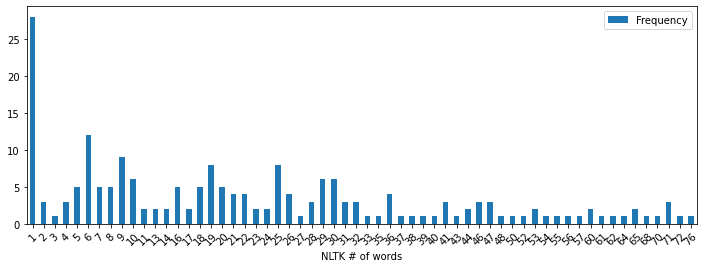

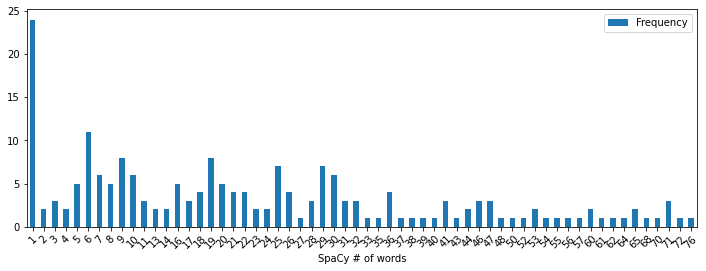

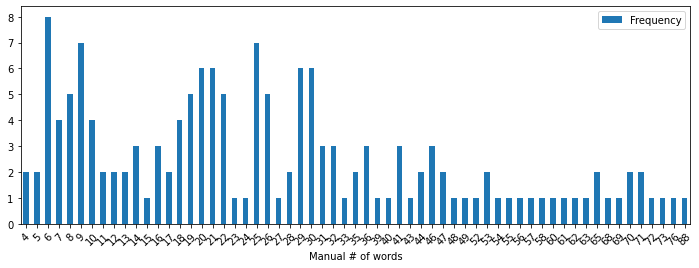

In [48]:
nltk_sents = get_nltk_sents(txt, es_tokenizer)
spacy_sents = get_spacy_sents(txt, es_nlp)
manual_sents = get_manual_sents(fname, lines)

print("Number of sentences identified by NLTK:", len(nltk_sents))
print("Number of sentences identified by spaCy:", len(spacy_sents))
print("Number of sentences identified by manual process:", len(manual_sents))
word_count_dist(nltk_sents, spacy_sents, manual_sents)

In [49]:
show_compare_sents(spacy_sents, nltk_sents, manual_sents)

Spacy sentence 0: DECRETO NUMERO CUATRO  El Concejo Municipal de Usulután, Departamento de Usulután,  CONSIDERANDO:  l.- Que existe una creciente preocupación de parte de este Concejo, por los problemas provocados por la contaminación sónica del municipio, ya que está ampliamente demostrado que a partir de determinados niveles, el ruido puede constituir una seria amenaza a la salud, un obstáculo al desarrollo económico y social y una vulneración a los derechos fundamentales de la persona.  
NLTK sentence 0: DECRETO NUMERO CUATRO  El Concejo Municipal de Usulután, Departamento de Usulután,  CONSIDERANDO:  l.- Que existe una creciente preocupación de parte de este Concejo, por los problemas provocados por la contaminación sónica del municipio, ya que está ampliamente demostrado que a partir de determinados niveles, el ruido puede constituir una seria amenaza a la salud, un obstáculo al desarrollo económico y social y una vulneración a los derechos fundamentales de la persona.
Manual sent

In [22]:
# Now let's get some sample sentences with a given length
def sample_sents_by_word_count(sents, word_count_range, sents_idx, random=False):
    result_sents = []
    word_counts = [len(str(sent).split()) for sent in sents]
    
    for sent, count in zip(sents, word_counts):
        if word_count_range[0] <= count <= word_count_range[1]:
            result_sents.append(sent)
    
    if random:
        return random.sample(result_sents, sents_idx[1])
    return result_sents[sents_idx[0]:sents_idx[1]]

In [23]:
sample_sents_by_word_count(nltk_sents, [1, 10], [0, 30])

['Follow the instructions on the website for  submitting comments.',
 'Instructions.',
 'Include the HHS Docket No.',
 'HRSA-2021-0001 in your  comments.',
 'All comments received will be posted without change to http://www.regulations.gov.',
 'The memorandum notes certain exceptions  that do not apply here.',
 'Id.',
 'Norris Cochran, Acting Secretary, Department of Health and Human Services.',
 '[FR Doc.',
 '2021-03069 Filed 2-11-21; 8:45 am] BILLING CODE 4165-15-P']

In [24]:
sample_sents_by_word_count(spacy_sents, [1, 10], [0, 30])

['Follow the instructions on the website for  submitting comments.     ',
 'Instructions.',
 'Include the HHS Docket No.',
 'HRSA-2021-0001 in your  comments.',
 'All comments received will be posted without change to http://www.regulations.gov.',
 "'' Id.",
 'Norris Cochran, Acting Secretary, Department of Health and Human Services.',
 '[FR Doc.',
 '2021-03069 Filed 2-11-21; 8:45 am] BILLING CODE 4165-15-P']

In [25]:
sample_sents_by_word_count(manual_sents, [20, 40], [0, 30])

['National Vaccine Injury Compensation Program: Revisions to the Vaccine Injury Table; Notice of Proposed Rulemaking; Public Comment Period; Delay of Effective Date AGENCY: Health Resources and Services Administration (HRSA), Department of Health and Human Services (HHS).',
 'HHS seeks comments on this proposed delay, which would allow it additional opportunity for review and consideration of the new rule.',
 'DATES: Written comments and related material to this proposed rule must be received to the online docket via https://www.regulations.gov on or before February 16, 2021.',
 'ADDRESSES: You may submit written comments electronically by the [[Page 9309]] following method: Federal eRulemaking Portal: http://www.regulations.gov. Follow the instructions on the website for submitting comments.',
 'Instructions. Include the HHS Docket No HRSA-2021-0001 in your comments. All comments received will be posted without change to http://www.regulations.gov. Please do not include any personally

## Export sentences

In [26]:
import json

def export_sentences(sents, fname):
    output = {}
    
    for i, sent in enumerate(sents):
        output[f"Sentence_{i}"] = sent
        
    fname_json = fname.replace(".txt", ".json")
    with open(fname_json, "w", encoding="latin-1") as fout:
        json.dump(output, fout, indent=4)

In [190]:
export_sentences(nltk_sents, f"nltk_{fname}")

## Process all 

In [50]:
base_path = "../input/USA/"
input_paths = usa_paths
tokenizer = en_tokenizer
nlp = en_nlp

for f_name in input_paths:
    txt_path = base_path + f_name
    fname = f_name.strip().replace(" ", "_").split(".")[0] + ".txt"
    
    with open(txt_path, "r") as txt_file:
        txt = txt_file.read()
        
    txt = remove_html_tags(txt).replace("\n", " ").replace("\t", " ").strip()
        
    nltk_sents = get_nltk_sents(txt, tokenizer)
    export_sentences(nltk_sents, f"../output/nltk_{fname}")
    
    spacy_sents = get_spacy_sents(txt, nlp)
    export_sentences(spacy_sents, f"../output/spacy_{fname}")
    
    with open(txt_path, "r") as txt_file:
        lines = txt_file.readlines()
    
    lines = [remove_html_tags(line).replace("\n", " ").replace("\t", " ").strip() for line in lines]
    manual_sents = get_manual_sents(fname, lines)
    export_sentences(manual_sents, f"../output/manual_{fname}")
    

## Observations

**TODO**:
- [x] Try looking at examples from different parts of the distribution
- [x] Check other documents - also Spanish from Chile and El Salvador
- [x] Compare with rule based system
- [x] Check how it handles semi-colons in Chile
- [ ] Add indicator of how many sentences per evaluation section

**General TODO**:
- Make sure to define the PDF reading part well

## Sentence splitting evaluation

----------------------------------
#### Some general evaluation criteria:

- "/" means good sentence
- "-/" means good sentence with a little bit of unnecessary additions
- "~/" means that it's understandable why this was considered (or not) a sentence, but it shouldn't have been because of how it works in the domain... in theory this is not bad, not taking points away for this
- "-" means not all the sentence was parsed/more than one sentences were parsed
- For non-clear sentences, we guide ourselves by the new line character
----------------------------------
### Chile

*Chile1.txt*

-> Evaluation substring:from the beginning until "Párrafo II"

- NLTK
	- Total identified sentences: 77
	- Identifies bullet points well, except the first one, if it comes after a heading like "Titulo I" or "Parrafo I", then the heading + the bullet point get processed
	- Overall gets everything right 
	- IMPORTANT: We should take a look at why the bullet points like "a)" got parsed correctly here but NOT in other document
	- Score: 21/21 

- Manual
	- Total identified sentces: 127
	- Gets rid of bullet points and letter/numbers (like a) or 1.) 
	- Also gets rid of words that appear a customizable stopwords list (such as "Decreto").
	- Score: 21/21

- SpaCy
	- Total identified sentences: 94
	- Similar to NLTK, the first bullets (like a)) can be appended to the heading, unnecessarily
	- Score: 21/21

*Chile2.txt*

-> Evaluation substring:from the beginning until "Lote 4 (b) de 1.171,08 hectáreas."

- NLTK
	- Total identified sentences: 192
	- Many badly split sentences here --> this time one sentence got split into multiple ones because of things like "ord." and "Sra." and "Corp." and "U.T.M."
	- Also that weird sentence with the V48 and V50... coordinates?
	- Score: 20/26
	- Error sentences:
		- Half:
			- Sentence_1
			- Sentence_14
			- Sentence_15
			- Sentence_16 
		- Full:
			- Sentence_2
			- Sentence_3
			- Sentence_20
			- Sentence_26
- Manual
	- Total identified sentences: 201
	- A bit of confusion between phrases ending in ";", and abreviations that use "."
	- Score: 23/26
	- Error sentences:
		- Half:
			- Sentence_3
			- Sentence_10
		- Full:
			- Sentence_20
			- Sentence_26
- Spacy
	- Total identified sentences: 88
	- Similar errors to NLTK
	- Score: 24.5/26
	- Error sentences:
		- Half:
			- Sentence_2
		- Full:
			- Sentence_3
			- Sentence_26

*Chile3.txt*

-> Evaluation substring:from the beginning until "(vi) panaderías que operen con combustible sólido y/o combustibles líquidos."

- NLTK
	- Total identified sentences: 59
	- Sentences 3-30 get put under the same one... because of a lack of period
	- Score: 3/61??????
	- Error sentences:
		- Sentence_3-Sentence_30?
		- Sentence_30-Sentence_56
		- Sentence_56-Sentence_61 
- Manual
	- Total identified sentences: 104
	- Most of the sentences got separated properly, except the ones that got separated by "S.A."
	- Error sentences:
		- Sentence_31-Sentence_33
		- Sentence_57-Sentence_61
- Spacy
	- Total identified sentences: 64
	- Random splits up to Sentence_10
	- Error sentences:
		- Sentence_10-Sentence_19
		- Sentence_22-Sentence-26
		- Sentence_26-Sentence_30
		- The rest...? There are bulet points that are joint together until sentence 9), Sentence_57-61


*General patterns to take in account for preprocessing*:
- Get rid of law numbers (Ley No 12.345) - splitting by space, identifying element next to No. and replacing with "Numero" and a random number.
- (PRIORITY) We need to do something about the bullet points like "a)"... Maybe we add a new line to the back, so it gets considered as a new sentence? Or we deal with them after the initial sentence splitting 
- Get rid of patterns like ".-" which are only confusing
- We can maybe get rid of periods that have a character with no space after them ("U.M" or "629.144" or "m.,", or ".(")
- Stopwords... are they useful? like "Articulo 7.-" or "Decreto:"... so far, they seem to not mess up with the sentence splitting system.
- (PRIORITY) Semicolons:
	- Get rid of semicolons? or replace them by periods? or replace them by spaces, or replace them by commas? 
	- When considering ";", we should check whether the next character is lowercase or not

----------------------------------
### USA

*USA_Sept302020.txt*

-> Evaluation substring:from the beginning until "Final Rule Issued Under Section 4(d) of the Act"

- NLTK
	- Total identified sentences: 244
	- Main errors come from confuesing docket numbers: "inspection at http://www.regulations.gov under Docket No. FWS-R4-ES-2018-0074."
	- Score: 41/43
	- Error sentences:
		- Half:
			- Sentence_7
			- Sentence_8
			- Sentence_9
			- Sentence_24


*General patterns to take in account for preprocessing:*
- Can filter out anything up to "ACTION: Final rule." or "-------------------" 
- We need to figure out how laws and docket numbers are represented, congressmen ("Cong."), sessions ("Sess."), district ("Dist.") numbers, etc.
- To figure out common patterns, we should grab everyting that comes before a "." and see if we can build them

----------------------------------
### El Salvador

*ElSalvador1.txt*


----------------------------------

### India



## Considerations

- How much do documents change over time per country? (2003 vs 2020)
- How much do documents change over local/state/federal level? (both English and Spanish)
- General concerns: Bullet points ("a)", "ii)") and acronyms/shortenings/references ("U.T.M", "Cong.", "ord.")